/var/folders/jf/m7m4d3dj54zgrgl_hgdy76g00000gn/T/ipykernel_41678/4041611699.py:40: RuntimeWarning: overflow encountered in exp
  fR = 1/(1 + np.exp(beta*(eps - mu_R)))


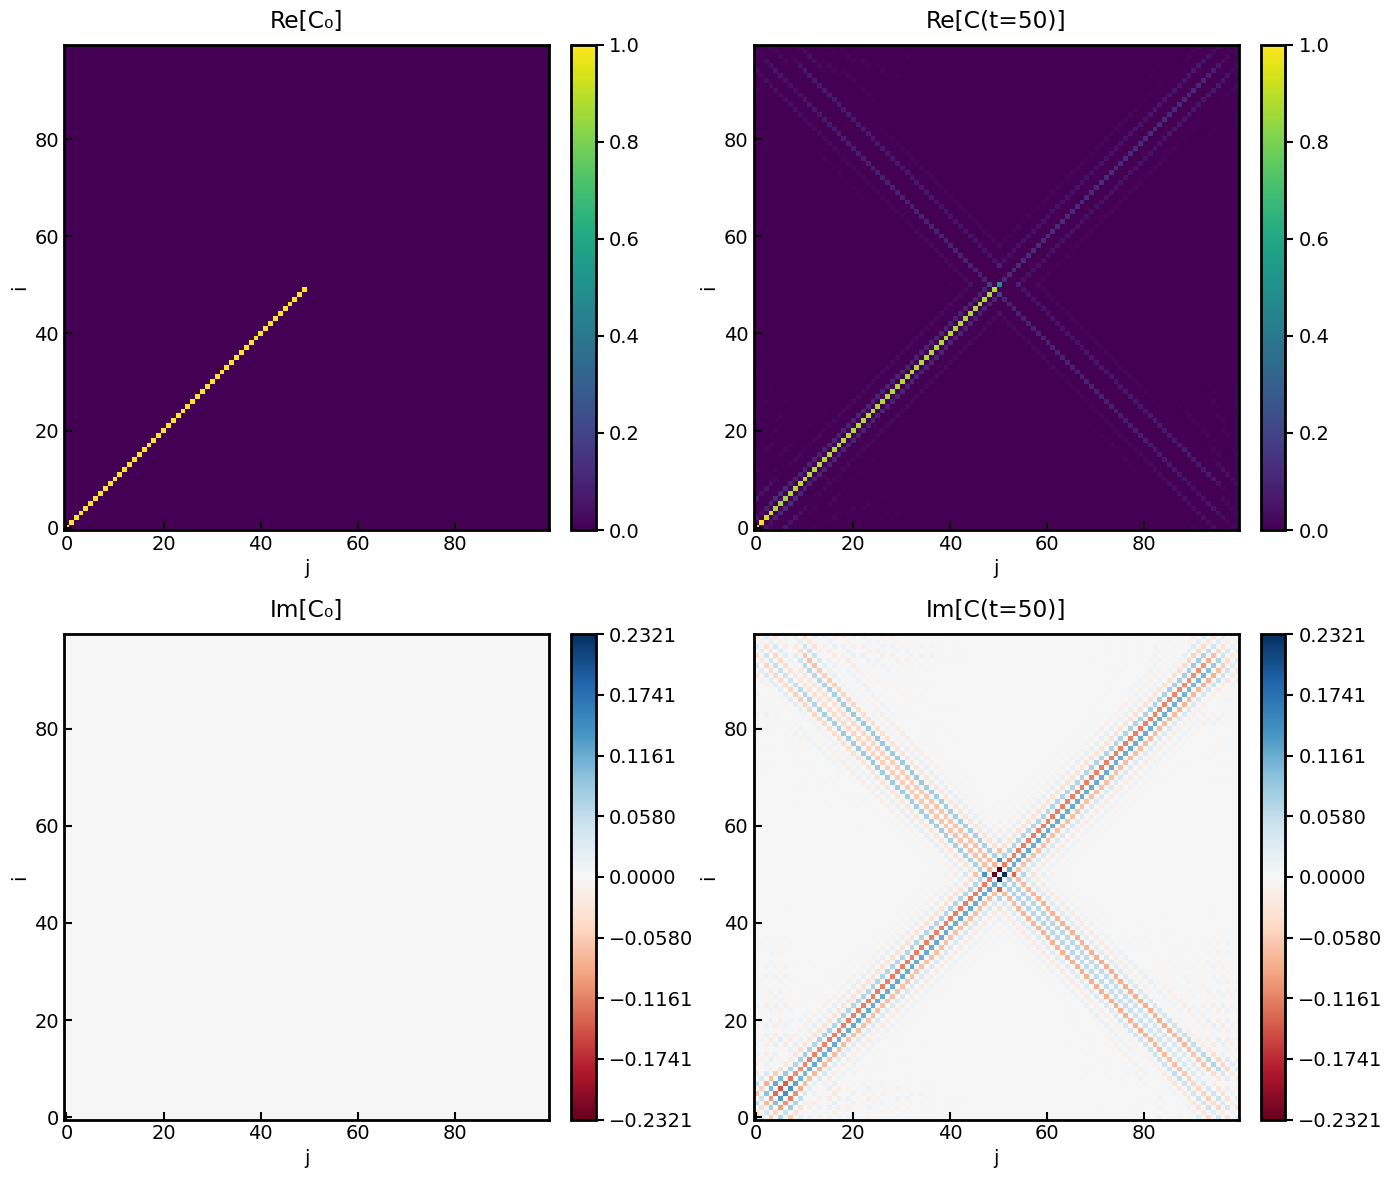

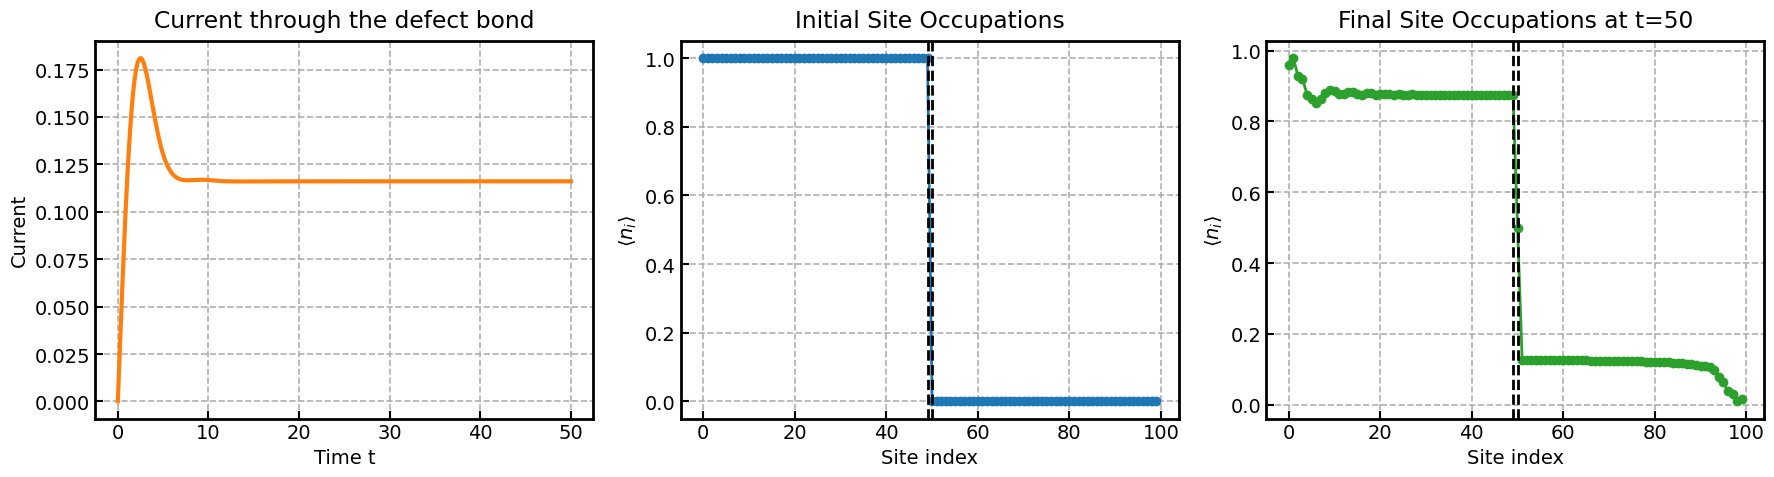

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

# Aesthetic settings
plt.rcParams.update({
    'font.size': 14,
    'axes.linewidth': 2,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'legend.fontsize': 12
})

# Model parameters
L, J, J_imp = 100, 1.0, 0.5
mu_L, mu_R = 1.0, -1.0
t_steady = 50.0
j0 = L//2 - 1

# 1) Build & diagonalize hopping Hamiltonian
def build_hopping_matrix(L, J, J_imp):
    center = L // 2
    h = np.zeros((L, L))
    for j in range(L - 1):
        if j == center - 1 or j == center:
            bond = J_imp
        else:
            bond = J
        h[j, j + 1] = h[j + 1, j] = bond / 2
    return h

h = build_hopping_matrix(L, J, J_imp)
eps, phi = la.eigh(h)

# 2) Initial correlation matrix
def initial_correlation_matrix(phi, eps, mu_L, mu_R, beta=1e6):
    fL = 1/(1 + np.exp(beta*(eps - mu_L)))
    fR = 1/(1 + np.exp(beta*(eps - mu_R)))
    CL = phi @ np.diag(fL) @ phi.conj().T
    CR = phi @ np.diag(fR) @ phi.conj().T
    C0 = np.zeros_like(CL, dtype=complex)
    C0[:j0+1, :j0+1] = CL[:j0+1, :j0+1]
    C0[j0+1:, j0+1:] = CR[j0+1:, j0+1:]
    return C0

C0 = initial_correlation_matrix(phi, eps, mu_L, mu_R)

# 3) Steady‐state correlation
U_steady = phi @ np.diag(np.exp(-1j*eps*t_steady)) @ phi.conj().T
C_steady = U_steady @ C0 @ U_steady.conj().T

# --- Block 1: 2×2 Re/Im panels ---
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Real parts
for ax, C, title in zip(axes[0], [C0, C_steady], ['Re[C₀]', f'Re[C(t={t_steady:.0f})]']):
    im = ax.imshow(np.real(C), origin='lower', vmin=0, vmax=1,
                   cmap='viridis', interpolation='nearest')
    ax.set_title(title, pad=12)
    ax.set_xlabel('j'); ax.set_ylabel('i')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, ticks=np.linspace(0,1,6))

# Imaginary parts
max_im = max(np.abs(np.imag(C0)).max(), np.abs(np.imag(C_steady)).max())
for ax, C, title in zip(axes[1], [C0, C_steady], ['Im[C₀]', f'Im[C(t={t_steady:.0f})]']):
    im = ax.imshow(np.imag(C), origin='lower', cmap='RdBu',
                   vmin=-max_im, vmax=max_im, interpolation='nearest')
    ax.set_title(title, pad=12)
    ax.set_xlabel('j'); ax.set_ylabel('i')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, ticks=np.linspace(-max_im, max_im, 9))

for ax in axes.flatten():
    ax.tick_params(direction='in', length=6, width=1.5)

plt.tight_layout()
plt.show()


# --- Block 2: current + occupations ---
# (a) current through defect bond; (b) initial <n_i>; (c) final <n_i>
times = np.linspace(0, t_steady, 300)
currents = []
for t in times:
    U_t = phi @ np.diag(np.exp(-1j*eps*t)) @ phi.conj().T
    Ct = U_t @ C0 @ U_t.conj().T
    currents.append(J_imp * np.imag(Ct[j0, j0+1]))

n_init  = np.real(np.diag(C0))
n_final = np.real(np.diag(C_steady))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# current
axes[0].plot(times, currents, '-', lw=3, color='tab:orange')
axes[0].set_title('Current through the defect bond', pad=10)
axes[0].set_xlabel('Time t'); axes[0].set_ylabel('Current')
axes[0].grid(True, linestyle='--', linewidth=1.2)

# initial occupations
axes[1].plot(range(L), n_init, 'o-', lw=2, markersize=6, color='tab:blue')
axes[1].set_title('Initial Site Occupations', pad=10)
axes[1].set_xlabel('Site index'); axes[1].set_ylabel(r'$\langle n_i\rangle$')
axes[1].axvline(j0,   color='k', linestyle='--', lw=2)
axes[1].axvline(j0+1, color='k', linestyle='--', lw=2)
axes[1].grid(True, linestyle='--', linewidth=1.2)

# final occupations
axes[2].plot(range(L), n_final, 'o-', lw=2, markersize=6, color='tab:green')
axes[2].set_title(f'Final Site Occupations at t={t_steady:.0f}', pad=10)
axes[2].set_xlabel('Site index'); axes[2].set_ylabel(r'$\langle n_i\rangle$')
axes[2].axvline(j0,   color='k', linestyle='--', lw=2)
axes[2].axvline(j0+1, color='k', linestyle='--', lw=2)
axes[2].grid(True, linestyle='--', linewidth=1.2)

for ax in axes:
    ax.tick_params(direction='in', length=6, width=1.5)

plt.tight_layout()
plt.show()